## Training Alexnet Model with IJEPA

### Importing Libraries

In [39]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import alexnet

#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Importing the CIFAR Dataset

In [40]:

# Load CIFAR dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 for AlexNet compatibility
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



Files already downloaded and verified


### Defining the Major Modules in IJEPA Architecture
- Encoder
- Predictor
- TargetEncoder

In [41]:
# Encoder class using AlexNet
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = alexnet(pretrained=False)
        self.model.classifier = nn.Sequential(*list(self.model.classifier.children())[:-1])  # Remove last layer

    def forward(self, x):
        return self.model(x)

# Target Encoder class with output dimension of 1024
class TargetEncoder(nn.Module):
    def __init__(self):
        super(TargetEncoder, self).__init__()
        self.model = alexnet(pretrained=False)
        self.model.classifier = nn.Sequential(
            *list(self.model.classifier.children())[:-1],  # Remove last layer
            nn.Linear(4096, 1024)  # Change to output 1024 dimensions
        )

    def forward(self, x):
        with torch.no_grad():  # Ensure target encoder doesn’t get updated
            return self.model(x)

# Predictor class for transforming context embeddings to predicted target embeddings
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(4096, 1024),  # Match context output size
            nn.ReLU(),
            nn.Linear(1024, 1024)   # Output size same as target encoder
        )

    def forward(self, x):
        return self.layers(x)




### Defining the Masking Strategy
- Random Masking

In [42]:
import random

# Masking Strategy class for masking random regions in the input images
class MaskingStrategy:
    def __init__(self, mask_size=(16, 16)):
        self.mask_size = mask_size  # Size of the mask to be applied

    def apply_mask(self, images):
        # Clone images to avoid modifying the original input
        masked_images = images.clone()

        # Get image dimensions
        _, _, h, w = images.shape
        mask_h, mask_w = self.mask_size

        # Ensure the random mask position fits within the image boundaries
        x = random.randint(0, h - mask_h)
        y = random.randint(0, w - mask_w)

        # Apply mask by setting a random region to zero
        masked_images[:, :, x:x + mask_h, y:y + mask_w] = 0
        return masked_images



### IJEPA Model

In [43]:
# IJEPA Model that combines Encoder, TargetEncoder, Predictor, and MaskingStrategy
class IJEPA_Model(nn.Module):
    def __init__(self):
        super(IJEPA_Model, self).__init__()
        self.encoder = Encoder()
        self.target_encoder = TargetEncoder()
        self.predictor = Predictor()
        self.masking_strategy = MaskingStrategy()

    def forward(self, images):
        # Context embedding from masked images
        context_embedding = self.encoder(images)

        # Target embedding from original images
        target_embedding = self.target_encoder(images)

        # Predict masked embeddings from context embedding
        predicted_embedding = self.predictor(context_embedding)

        return predicted_embedding, target_embedding


### Training Loop

In [62]:
import os

# Training loop with multiple random masks per image
def train(model, dataloader, epochs=10, lr=1e-2, num_masks=4, save_interval=2, checkpoint_dir='checkpoints'):
    model.train()
    model.to(device)  # Move model to GPU
    criterion = nn.CosineEmbeddingLoss()  # Cosine similarity for embedding loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # List to store loss values for plotting
    epoch_losses = []

    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    print("Training Started...")
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)  # Move data to GPU

            # Accumulate loss for multiple masked versions
            batch_loss = 0.0

            for _ in range(num_masks):
                # Apply random masking to the images
                masked_images = model.masking_strategy.apply_mask(images)

                # Forward pass
                predicted_embedding, target_embedding = model(masked_images)

                # Cosine similarity loss (target label for similarity is 1)
                target = torch.ones(predicted_embedding.size(0)).to(device)
                loss = criterion(predicted_embedding, target_embedding.detach(), target)

                # Accumulate the loss
                batch_loss += loss

            # Average the loss over multiple masks
            batch_loss /= num_masks

            # Backward pass and optimization
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss.item()

        # Append average epoch loss
        epoch_losses.append(epoch_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

        # Save checkpoint every few epochs
        if (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

    return epoch_losses  # Return the list of epoch losses

### Start Training

In [63]:
# Initialize model and start training
model = IJEPA_Model()
losses = train(model, train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training Started...
Epoch [1/10], Loss: 25.3898
Epoch [2/10], Loss: 24.1548
Checkpoint saved: checkpoints/checkpoint_epoch_2.pth
Epoch [3/10], Loss: 24.1628
Epoch [4/10], Loss: 24.1703
Checkpoint saved: checkpoints/checkpoint_epoch_4.pth
Epoch [5/10], Loss: 24.1532
Epoch [6/10], Loss: 24.1575
Checkpoint saved: checkpoints/checkpoint_epoch_6.pth
Epoch [7/10], Loss: 24.1522
Epoch [8/10], Loss: 24.1407
Checkpoint saved: checkpoints/checkpoint_epoch_8.pth
Epoch [9/10], Loss: 24.1374
Epoch [10/10], Loss: 24.1308
Checkpoint saved: checkpoints/checkpoint_epoch_10.pth


### Plotting Loss over Epochs

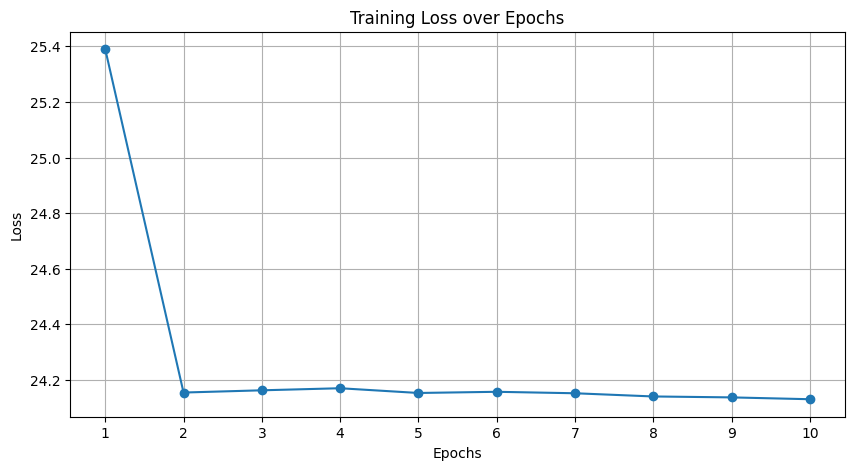

In [64]:
import matplotlib.pyplot as plt

# Plotting the loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(losses) + 1))  # Set x-ticks to be epoch numbers
plt.grid()
plt.show()